In [59]:
# Here we calculate the mass gap in the following ways (m1 = heaviest still):
# m1 - mean(satellites), m1 - median(satellites)
import astropy.io.fits as fits
import numpy as np
from astropy.table import unique,Table,setdiff,hstack,join
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

MassGapData = Table.read('/suphys/fscu5535/python_scripts/mod_data/ImprovedDataMassGapMethod3.fits',memmap=True)
MassGapData.info()
print(MassGapData)

<Table length=2716>
    name     dtype     unit      class     n_bad
----------- ------- --------- ------------ -----
     CATAID   int64           MaskedColumn     0
    GroupID   int32           MaskedColumn     0
RankIterCen   int16           MaskedColumn     0
   logmstar float32 dex(Msun)       Column     0
 LAMBDAR_RE float64                 Column  2076
 CATAID GroupID RankIterCen  logmstar     LAMBDAR_RE    
                            dex(Msun)                   
------- ------- ----------- --------- ------------------
   6837  203007           1   9.82991                nan
   6838  203007           2 9.3911085                nan
   7203  203039           2 10.380958                nan
   7206  203039           1 10.410899 0.5493758320808411
   7289  203048           1 11.081309 0.0719321072101593
   7293  203048           2  9.731596                nan
    ...     ...         ...       ...                ...
3634416  101283           4  9.093014                nan
3634544  1

In [20]:
# group data by GroupID and then sort by logmstar
MassGapDataGrouped = MassGapData.group_by('GroupID')
MassGapDataGrouped.sort(['GroupID','logmstar'])
print(MassGapDataGrouped.groups[40])

CATAID GroupID RankIterCen  logmstar      LAMBDAR_RE    
                           dex(Msun)                    
------ ------- ----------- --------- -------------------
380713  100987           4   9.64605                 nan
380699  100987           3  9.756094                 nan
380698  100987           2 10.720544                 nan
380697  100987           1 10.866109 0.24692468345165253


In [26]:
# calculate the mean/median for just the satellites. Manually checked these and they are correct
print("Mean is:",np.mean(MassGapDataGrouped.groups[40]['logmstar'][:-1]))
print("Median is:",np.median(MassGapDataGrouped.groups[40]['logmstar'][:-1]))

Mean is: 10.040896
Median is: 9.756094


In [79]:
# Now calculate this for every group, storing in two lists
satelliteMean = list()
satelliteMedian = list()
groupID = list()
for i in range(len(MassGapDataGrouped.groups)):
    satelliteMean.append(np.mean(MassGapDataGrouped.groups[i]['logmstar'][:-1]))
    satelliteMedian.append(np.median(MassGapDataGrouped.groups[i]['logmstar'][:-1]))
    groupID.append(MassGapDataGrouped.groups[i]['GroupID'][0])
    
print(len(satelliteMean),"group satellite means calculated")
print(len(satelliteMedian),"group satellite medians calculated")
print(len(groupID),"groups in total")

MeanMediantable = Table()
MeanMediantable['GroupID'] = groupID
MeanMediantable['SatMean'] = satelliteMean
MeanMediantable['SatMedian'] = satelliteMedian

598 group satellite means calculated
598 group satellite medians calculated
598 groups in total


In [82]:
# Now check that this is ok
print(MassGapDataGrouped.groups[0])

print("Mean:",satelliteMean[0])
print("Median:",satelliteMedian[0])

CATAID GroupID RankIterCen  logmstar      LAMBDAR_RE    
                           dex(Msun)                    
------ ------- ----------- --------- -------------------
372163  100006          17  8.714643                 nan
372222  100006          48  8.915278                 nan
372185  100006          32  8.935463                 nan
372164  100006           6  9.201263                 nan
372221  100006          40  9.235959                 nan
372189  100006          28  9.351252                 nan
   ...     ...         ...       ...                 ...
372171  100006          44 10.520071                 nan
372177  100006          43 10.557999                 nan
372176  100006          51 10.572487                 nan
372126  100006          13 10.587907                 nan
376633  100006          54 10.628587                 nan
301599  100006          16 10.834722                 nan
372123  100006           1 11.250554 0.11300508677959442
Length = 54 rows
Mean: 9.887333

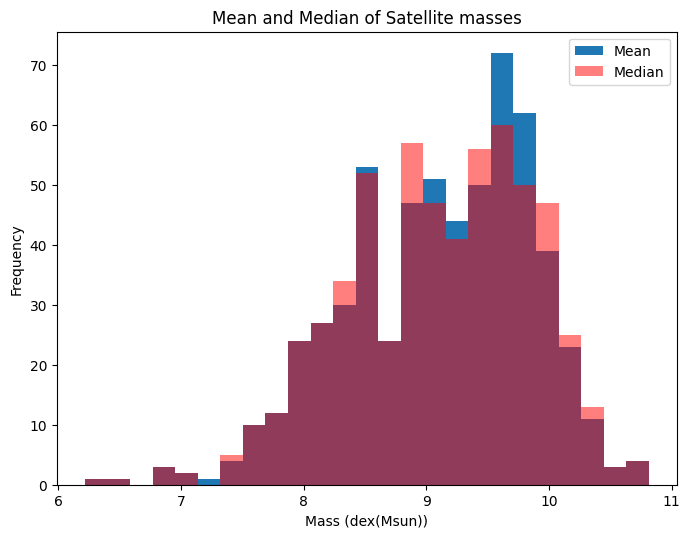

In [111]:
# Plot distributions to see if there's any outliers
plt.figure(figsize=(8, 6), dpi=100)
MeanPlot = plt.hist(satelliteMean,bins=25)
MedianPlot = plt.hist(satelliteMedian,bins=25,alpha=0.5, color = 'r')
plt.title("Mean and Median of Satellite masses")
plt.xlabel("Mass (dex(Msun))")
plt.ylabel("Frequency")
plt.legend(['Mean','Median'])

In [80]:
# So the distribution is fairly normal. The low mean/median satellite masses are probably
# galaxy pairs where m2 is low. Now read in latest massgap data with MassA log(MassA)/m1 etc and join
combinedData = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps3.0.fits',memmap=True)
NewCombinedData = join(combinedData,MeanMediantable,keys='GroupID',join_type='left')
NewCombinedData.info()

<Table length=552>
     name      dtype   unit     class     n_bad
------------- ------- ------ ------------ -----
      GroupID   int32        MaskedColumn     0
   log(MassA) float64              Column     0
    m1_CATAID   int64        MaskedColumn     0
    m2_CATAID   int64        MaskedColumn     0
           m1 float32              Column     0
           m2 float32              Column     0
       deltaM float32              Column     0
m1_LAMBDAR_RE float64              Column   120
         Nfof   int16        MaskedColumn     0
        MassA float32 Msun/h       Column     0
log(MassA)/m1 float64              Column     0
      SatMean float32              Column     0
    SatMedian float32              Column     0


In [87]:
# Check data, rename mass gap column and then write to file
print(NewCombinedData[0])
NewCombinedData.write('/suphys/fscu5535/python_scripts/mod_data/massGaps3.1.fits',overwrite = True)

GroupID     log(MassA)     m1_CATAID m2_CATAID     m1        m2      m1-m2       m1_LAMBDAR_RE    Nfof       MassA         log(MassA)/m1    SatMean  SatMedian
                                                                                                             Msun/h                                           
------- ------------------ --------- --------- --------- --------- ---------- ------------------- ---- ----------------- ------------------ -------- ---------
 100006 14.075298715297198    372123    301599 11.250554 10.834722 0.41583252 0.11300508677959442   54 118932000000000.0 1.2510760456092813 9.887333  9.826758


In [90]:
# Data looks good. Now recalculate the mass gap using m2 = {SatMean, SatMedian} and then compare all 3
latestMassGaps = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps3.1.fits',memmap=True)

massGapMean = list()
massGapMedian = list()

for i in range(len(latestMassGaps)):
    massGapMean.append(latestMassGaps[i]['m1'] - latestMassGaps[i]['SatMean'])
    massGapMedian.append(latestMassGaps[i]['m1'] - latestMassGaps[i]['SatMedian'])

# join with data and write to file
latestMassGaps['m1-SatMean'] = massGapMean
latestMassGaps['m1-SatMedian'] = massGapMedian
latestMassGaps.write('/suphys/fscu5535/python_scripts/mod_data/massGaps3.2.fits',overwrite=True)


In [104]:
# Changing columns around and checking that mass gaps calculated properly
Data = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps3.2.fits',memmap=True)
Data.info()
Data['newlog'] = Data['log(MassA)']
Data.remove_column('log(MassA)')
Data.rename_column('newlog','log(MassA)')
Data.info()
Data.write('/suphys/fscu5535/python_scripts/mod_data/massGaps3.2.1.fits',overwrite=True)

print(latestMassGaps[0])

<Table length=552>
     name      dtype   unit     class     n_bad
------------- ------- ------ ------------ -----
      GroupID   int32        MaskedColumn     0
   log(MassA) float64              Column     0
    m1_CATAID   int64        MaskedColumn     0
    m2_CATAID   int64        MaskedColumn     0
           m1 float32              Column     0
           m2 float32              Column     0
        m1-m2 float32              Column     0
m1_LAMBDAR_RE float64              Column   120
         Nfof   int16        MaskedColumn     0
        MassA float32 Msun/h       Column     0
log(MassA)/m1 float64              Column     0
      SatMean float32              Column     0
    SatMedian float32              Column     0
   m1-SatMean float32              Column     0
 m1-SatMedian float32              Column     0
<Table length=552>
     name      dtype   unit     class     n_bad
------------- ------- ------ ------------ -----
      GroupID   int32        MaskedColumn     0
  

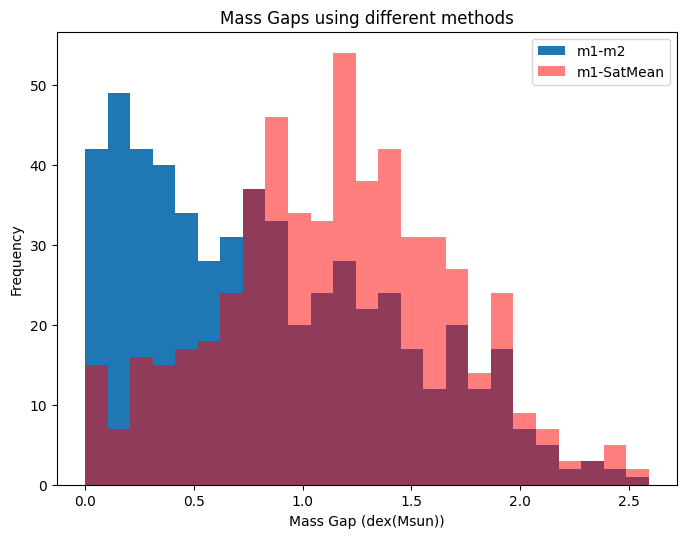

In [110]:
# Plot histograms
plt.figure(figsize=(8, 6), dpi=100)
massGapm2 = plt.hist(Data['m1-m2'],bins=25)
massGapSatMean = plt.hist(Data['m1-SatMean'],bins=25,color='r',alpha=0.5)
plt.title("Mass Gaps using different methods")
plt.xlabel("Mass Gap (dex(Msun))")
plt.ylabel("Frequency")
plt.legend(['m1-m2','m1-SatMean'])


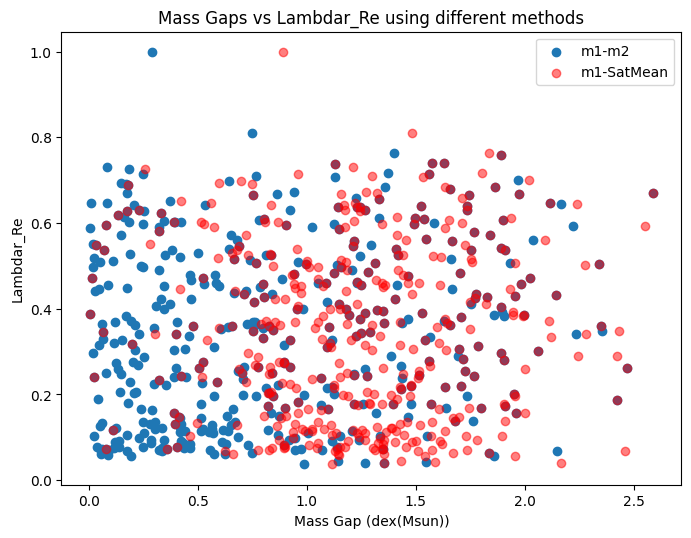

In [118]:
# Now plot mass gaps vs lambdar_re for both methods
plt.figure(figsize=(8, 6), dpi=100)
massGapm2Lambdar = plt.scatter(Data['m1-m2'],Data['m1_LAMBDAR_RE'])
massGapSatMeanLambdar = plt.scatter(Data['m1-SatMean'],Data['m1_LAMBDAR_RE'],color='r',alpha=0.5)
plt.title("Mass Gaps vs Lambdar_Re using different methods")
plt.xlabel("Mass Gap (dex(Msun))")
plt.ylabel("Lambdar_Re")
plt.legend(['m1-m2','m1-SatMean'])